In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_theme()
pd.options.display.float_format = None

# https://www.kaggle.com/datasets/beatafaron/fmcg-daily-sales-data-to-2022-2024

In [2]:
def read_data():
    data = pd.read_csv(r"C:\Users\flori\Documents\Github\Forecasting\data\FMCG_2022_2024.csv")
    return data

data = read_data()

# 1 Data Wrangling

In [3]:
# Convert date into datetime and set as index
def convert_date(df):
    # Convert into datetime
    df["date"] = pd.to_datetime(df["date"])
    # Set as index
    df = df.set_index("date")

    return df

data = convert_date(data)

In [4]:
# Inspect Object Characteristics
for i in data.columns:
    if data[i].dtype == 'object':
        print(f"{i}: \n {data[i].unique()} \n")

sku: 
 ['MI-006' 'MI-026' 'YO-029' 'YO-005' 'YO-012' 'YO-014' 'YO-001' 'RE-004'
 'RE-007' 'RE-015' 'MI-023' 'JU-021' 'YO-009' 'SN-027' 'YO-003' 'MI-022'
 'YO-016' 'RE-025' 'SN-010' 'RE-017' 'SN-013' 'YO-020' 'SN-019' 'MI-002'
 'MI-011' 'YO-024' 'MI-008' 'SN-028' 'YO-018' 'SN-030'] 

brand: 
 ['MiBrand1' 'MiBrand4' 'YoBrand4' 'YoBrand2' 'YoBrand1' 'YoBrand3'
 'ReBrand1' 'ReBrand4' 'MiBrand3' 'JuBrand3' 'SnBrand2' 'ReBrand2'
 'SnBrand3' 'MiBrand2'] 

segment: 
 ['Milk-Seg3' 'Milk-Seg2' 'Yogurt-Seg2' 'Yogurt-Seg1' 'Yogurt-Seg3'
 'ReadyMeal-Seg2' 'ReadyMeal-Seg1' 'Juice-Seg3' 'SnackBar-Seg3'
 'ReadyMeal-Seg3' 'SnackBar-Seg2' 'SnackBar-Seg1' 'Milk-Seg1'] 

category: 
 ['Milk' 'Yogurt' 'ReadyMeal' 'Juice' 'SnackBar'] 

channel: 
 ['Retail' 'Discount' 'E-commerce'] 

region: 
 ['PL-Central' 'PL-North' 'PL-South'] 

pack_type: 
 ['Multipack' 'Single' 'Carton'] 



In [5]:
# Check Missing Values
data.isnull().sum().sum()

0

In [6]:
# Check Duplicates
data.duplicated().sum()

0

In [7]:
# Check for negative values
for i in data.columns:
    if data[i].dtype in ("int64", "int32","float64"):
        print(f"{i}: {(data[i] < 0).any()}")

price_unit: False
promotion_flag: False
delivery_days: False
stock_available: True
delivered_qty: True
units_sold: True


In [8]:
# Delete negative values
data = data[~data["delivered_qty"] < 0]

# 2 Exploratory Data Analysis

## 2.1 Target

### 2.1.1 Trajectory over Time

In [9]:
# Trajectory of Overall Sales over Time
daily_sales_overall = data.resample("D")["units_sold"].sum()

# Plot
fig = px.line(data_frame=daily_sales_overall, x=daily_sales_overall.index, y="units_sold", title="Daily Overall Sales over Time")
fig.show()


In [10]:
# Trajectory of Sales per Category over Time
daily_sales_each_category = data.groupby([pd.Grouper(freq="D"),"category"])["units_sold"].sum().unstack()

# Plot
fig = px.line(daily_sales_each_category, title="Daily Sales per Category over Time")
fig.show()

### 2.1.2 Random Weekly Distribution

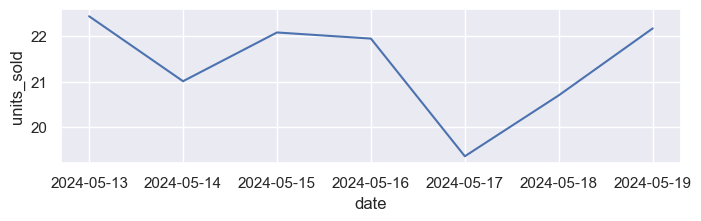

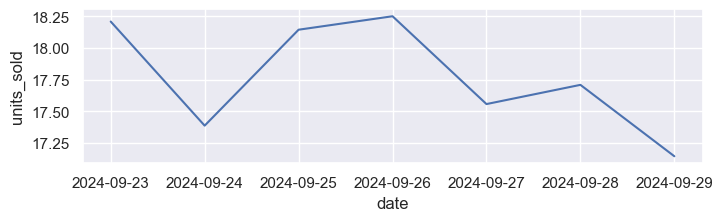

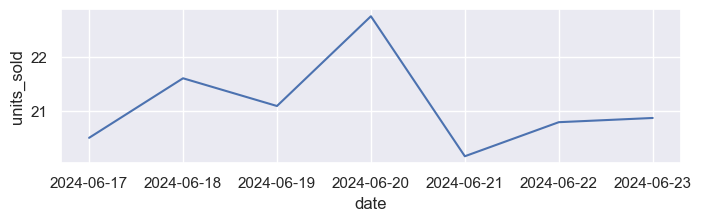

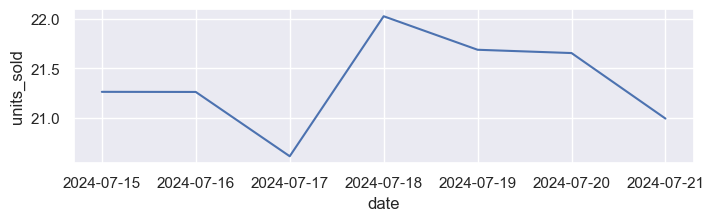

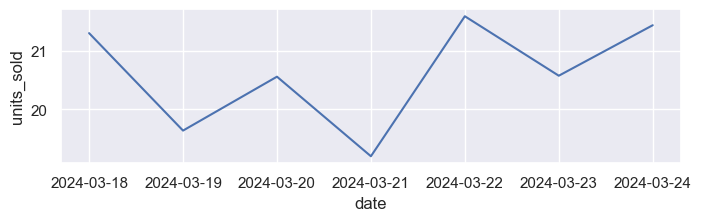

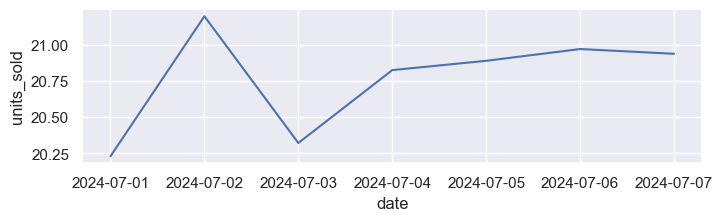

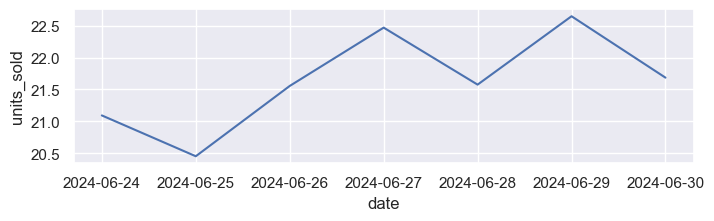

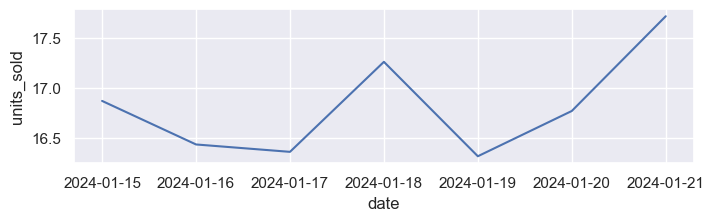

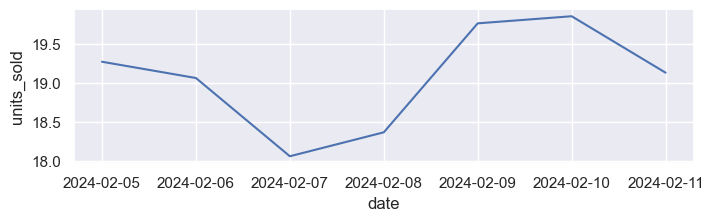

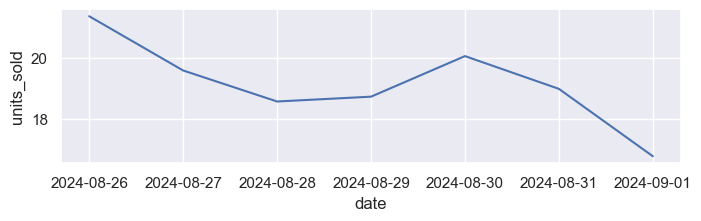

In [ ]:
'''
This sampling aims to zoom in to random weeks to explore weekly patterns

'''


# New Column 'Week'
data["week"] = data.index.isocalendar().week

# Index '2024'
date_2024 = data.loc["2024-01-01":"2024-12-31"]

# Random Samples of Weeks
sample_weeks = []

np.random.seed(42)
for _ in range(10):
    weeks = date_2024.week.unique()
    sample = np.random.choice(weeks, replace=False)
    sample_df = date_2024[date_2024.week == sample]
    sample_weeks.append(sample_df)

# Plot Weekly Distribution
for i in sample_weeks:
    plt.figure(figsize=(8,2))
    sns.lineplot(data=i, x=i.index, y="units_sold", errorbar=None)

### 2.1.3 Autocorrelation

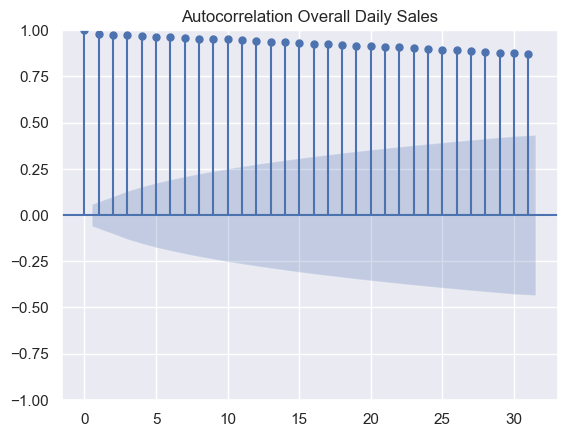

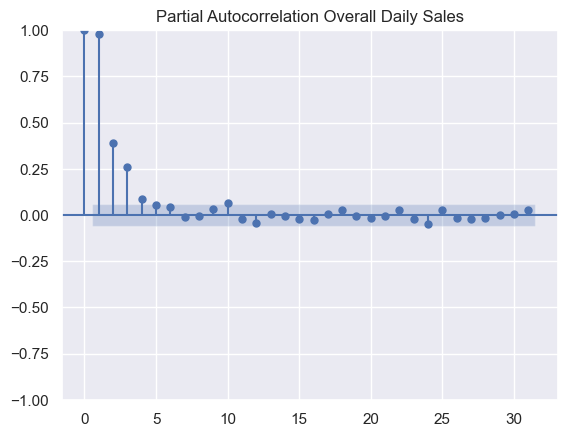

In [12]:
# (Partial) Autocorrelation Function (ACF, PCAF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

autocorr_df = data.units_sold.resample("D").sum()

acf_plot = plot_acf(autocorr_df, title="Autocorrelation Overall Daily Sales")
pacf_plot = plot_pacf(autocorr_df, title="Partial Autocorrelation Overall Daily Sales")

## 2.2 Features

### 2.2.1 Distribution Region, Channel, Pack Type, Promotion Flag

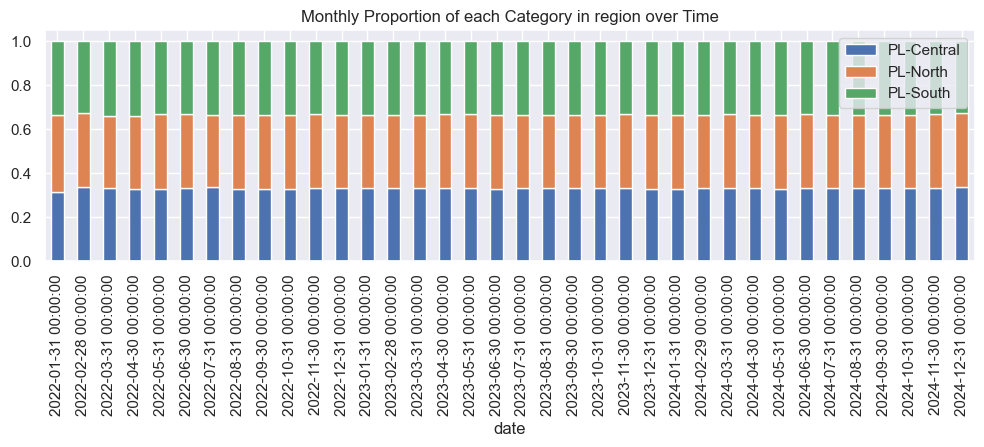

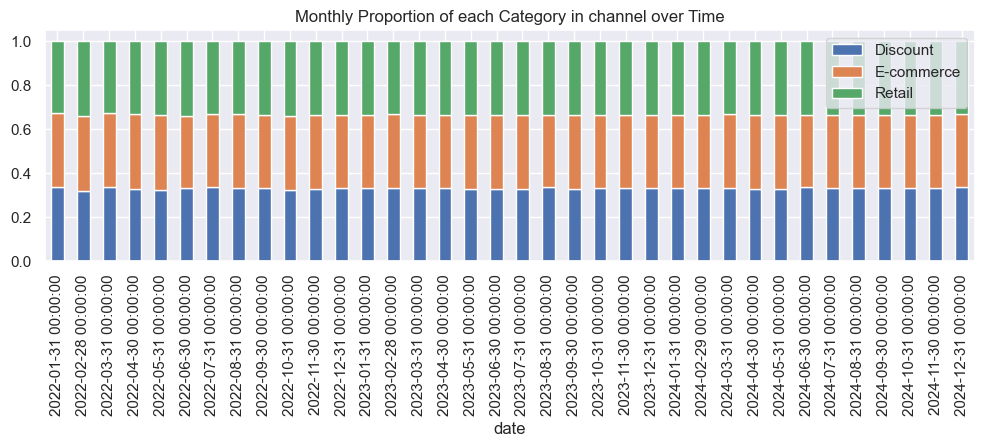

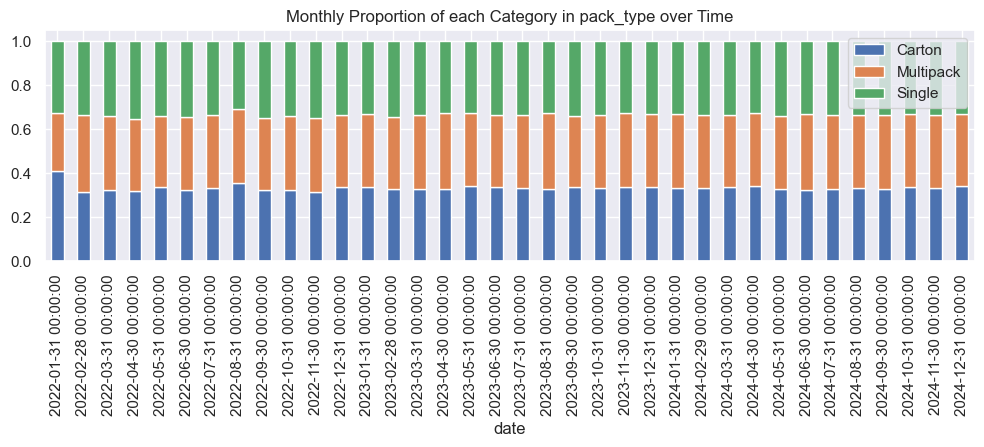

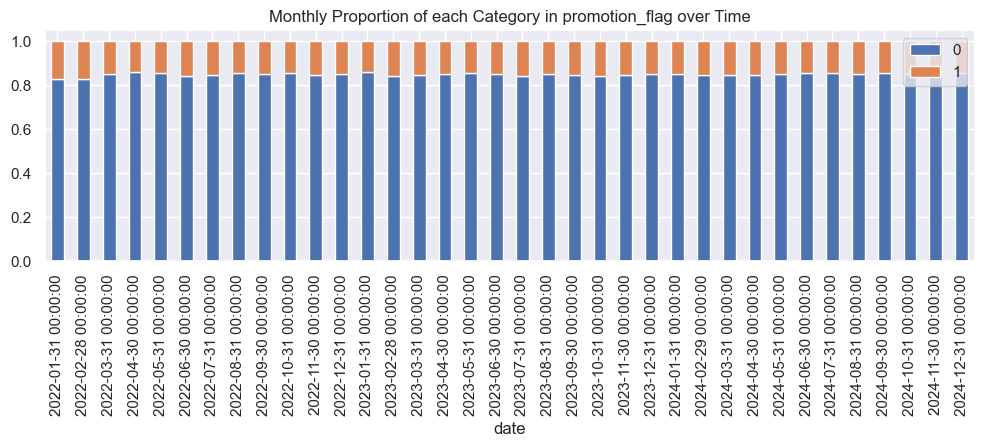

In [13]:
for col in ["region", "channel", "pack_type", "promotion_flag"]:
    data.groupby(pd.Grouper(freq="ME"))[col] \
      .value_counts(normalize=True) \
      .unstack() \
      .plot(kind="bar",
      figsize=(12,3),
      stacked=True,
      title=f"Monthly Proportion of each Category in {col} over Time")
    plt.legend(loc="upper right");
    

### 2.2.2 Analysis Price Unit

In [14]:
change_price_unit = data.price_unit.resample("W").mean().diff().dropna()

fig = px.line(data_frame=change_price_unit, title="Weekly Change in Mean Price Unit")
fig.show()

# 3 Simulate Forecast Environment

In [15]:
data["weekday"] = data.index.weekday

sample_days_urn = []
sample_days_agg = []


for day in range(0, 6):
    sample = data[data.weekday == day]
    sample_list = sample.groupby(sample.index)["price_unit"].mean()
    sample_days_urn.append(sample_list)

    
    agg = sample_list.agg(["mean", "median", "std", "min", "max"])
    sample_days_agg.append(agg)

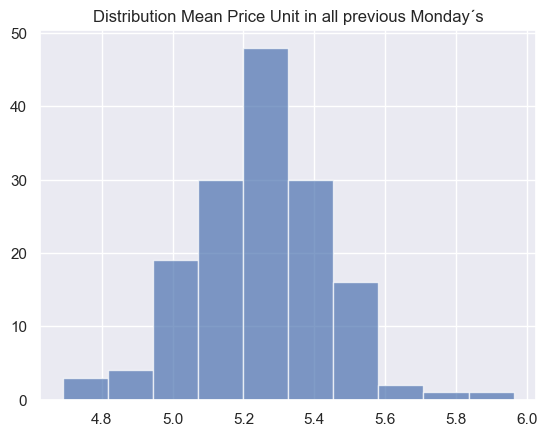

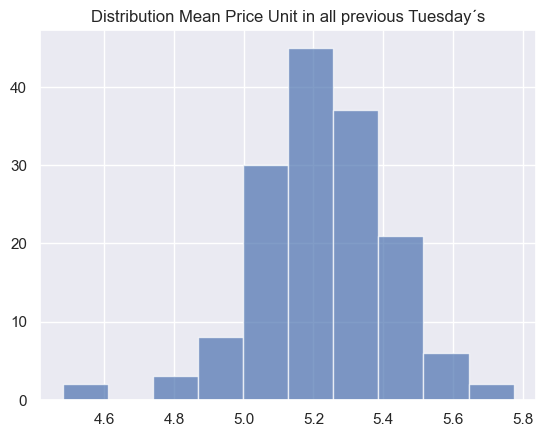

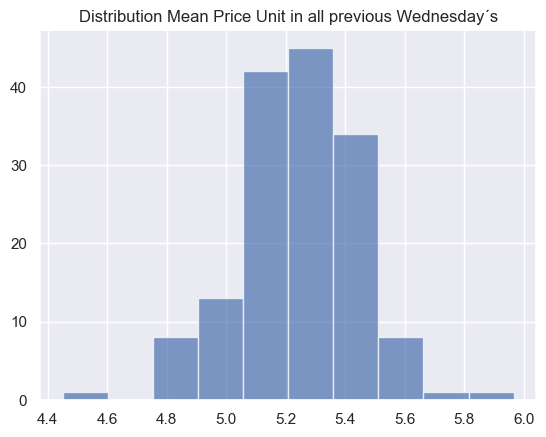

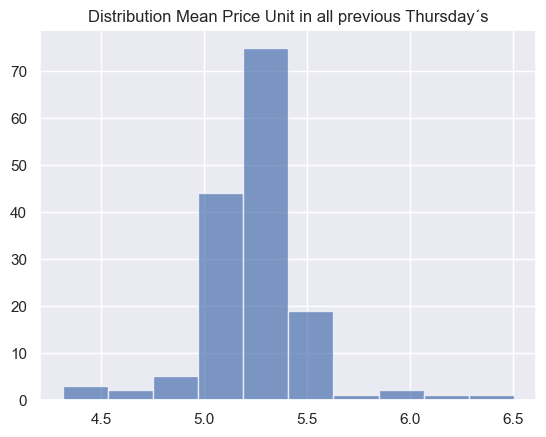

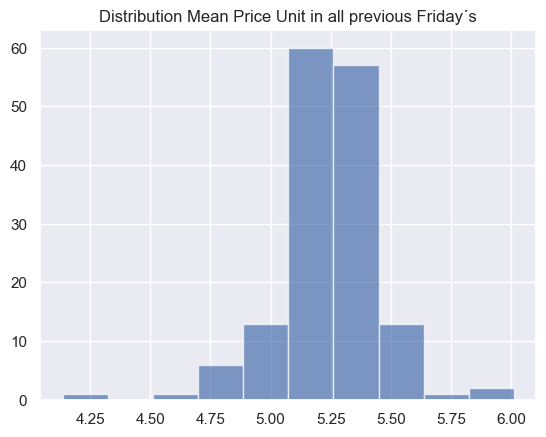

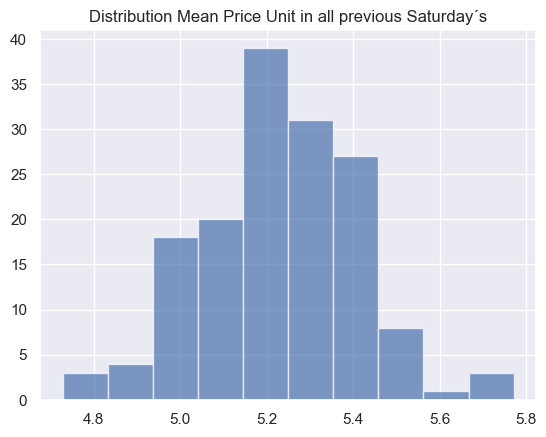

In [16]:
days_dict = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday"}
for i, days in days_dict.items():
    sample_days_urn[i].hist(alpha=0.7)
    plt.title(f"Distribution Mean Price Unit in all previous {days}´s")
    plt.show()

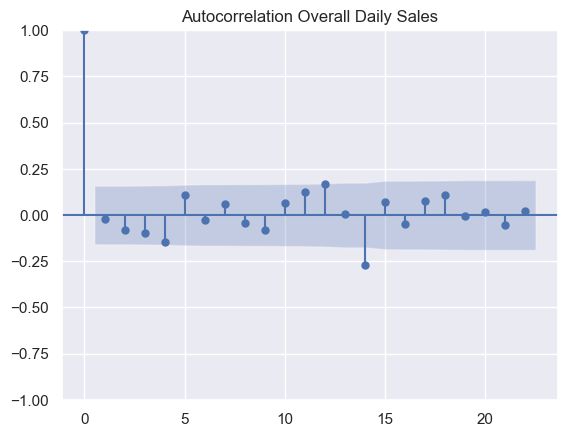

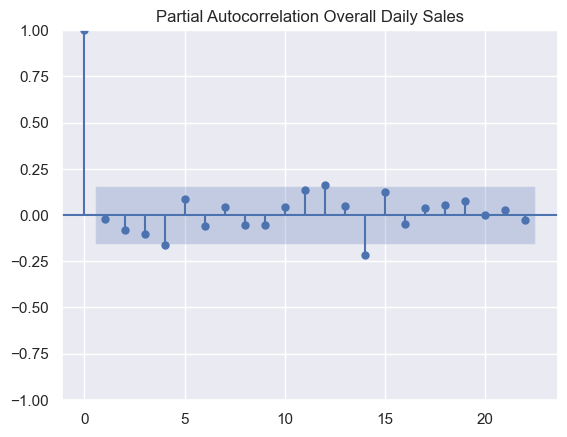

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


acf_plot = plot_acf(sample_days_urn[0], title="Autocorrelation Overall Daily Sales")
pacf_plot = plot_pacf(sample_days_urn[0], title="Partial Autocorrelation Overall Daily Sales")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

# Daily Means
data_daily = data[["units_sold", "delivered_qty", "stock_available", "price_unit"]].resample("D").mean()

# Extract Values
X = data_daily.values

# Fit Transform X
scaled = mms.fit_transform(X)

# Create DataFrame
norm_df = pd.DataFrame(
    scaled,
    index=data_daily.index,
    columns=["units_sold", "delivered_qty", "stock_available", "price_unit"]
)

In [19]:
fig = px.line(data_frame=norm_df, 
              y=["units_sold", "delivered_qty", "stock_available", "price_unit"], 
              title="Trajectory MinMaxScaled")
fig.show()